# Whisper Model (Wav2vec) Evaluation On Audio Length

1. Compute Audio Length for Each Transcription
2. Compute Error
3. Generate Plots
***
### Error Metrics
1. WER
2. ROUGE

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [1]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


***

# Imports & Ingestion of Data (Wav2vec)
**We will be using the data generated from `wav2vec-stu-eval.ipynb`.**

In [1]:
import pandas as pd
import numpy as np
import scipy 
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 

cols = list(pd.read_csv("net_aigenerated_data_wav2vec_performance_stu.csv", nrows=1))
print(cols)

net_aigenerated_data_wav2vec = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/net_aigenerated_data_wav2vec_performance_stu.csv', delimiter=',', usecols =[i for i in cols if "Unnamed:" not in i])

['Unnamed: 0', 'Filename', 'Start_time', 'End_time', 'Wav2vec', 'WER', 'Stutterance_Count', 'NA_Count', 'NA_Cleaned_Count', 'WER_Binned', 'rouge1-precision', 'rouge1-recall', 'rouge1-f1', 'rouge2-precision', 'rouge2-recall', 'rouge2-f1', 'rougel-precision', 'rougel-recall', 'rougel-f1', 'Cleaned_Transcript', 'GroundTruth_Transcript']


In [10]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [11]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [12]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [13]:
## Assign back the cleaned transcript and original transcript
merged_data = net_aigenerated_data_wav2vec.merge(
    net_data[['Filename', 'Start_time', 'Cleaned_Transcript', 'Transcript']],
    on=['Filename', 'Start_time'],
    how='left'
)

net_aigenerated_data_wav2vec['Cleaned_Transcript'] = merged_data['Cleaned_Transcript']
net_aigenerated_data_wav2vec['GroundTruth_Transcript'] = merged_data['Transcript']

In [3]:
net_aigenerated_data_wav2vec

,Filename,Start_time,End_time,Wav2vec,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,WER_Binned,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1,Cleaned_Transcript,GroundTruth_Transcript
0,D0001_A,2081.540000,2109.650000,我说出了就比较需要时间然后那识别了他的不就是他的一会那个话还没说完的描说出来的话它就取消不就...,0.350515,1.0,589,0,0.35,0.722222,0.684211,0.702703,0.346939,0.278689,0.309091,0.648148,0.500000,0.564516,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,我说出来就比较的需要时间，哦，然后那个嗯/i识别的它的就是它等你一会儿，你那个话还没有说完，...
1,D0001_A,790.130000,796.580000,四治表我尔说的法,0.700000,1.0,589,0,0.70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,电视剧有，我说的话。,电视剧有，我/r说的话。
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评中不怎么好的就而论区的那那县人他们都在说拿号作朝惨的那个就那么请奋但是就是了...,0.375000,10.0,589,0,0.38,0.566667,0.548387,0.557377,0.352941,0.300000,0.324324,0.600000,0.500000,0.545455,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,这/b部剧是不怎么，评分是不怎么好的，呃/i就因为呃/i评/r/b论区的那[那]些人，他们都...
3,D0001_A,2016.780000,2035.673559,很金转和训非女婴还是讯本一助手来的就就我记的他是叫迅菲我之前甲就是他,0.578947,7.0,589,0,0.58,0.476190,0.500000,0.487805,0.208333,0.178571,0.192308,0.440000,0.354839,0.392857,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,很[很/b]精准，对，呃/i讯飞语音还是讯飞助手来着，就[就]我记得它是叫讯/r飞，我之前就...
4,D0001_A,1682.670000,1709.110000,一个那个是你较扎来的果望了是出现了与一个人然后了他他就这了一把健然后就交瓦那个拿二奥给早萨尔...,0.455882,8.0,589,0,0.46,0.500000,0.454545,0.476190,0.179487,0.159091,0.168675,0.550000,0.448980,0.494382,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,一个那个是嗯/i叫啥来着，我忘了，就是出现了另/r/b一个人，然后呢他[他]就射/p了一把剑...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,589,0,0.09,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091,单曲循环歌曲这样而已。,单曲循环歌曲这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,589,0,0.17,1.000000,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143,杨幂的电影。,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米亚今天柴油价怎么样,0.266667,0.0,589,0,0.27,0.833333,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667,你好，米雅，今天柴油价怎么样。,你好，米雅，今天柴油价怎么样。
37251,P0070,2604.066000,2606.656000,单曲循环歌曲刘离光之歌,0.250000,0.0,589,0,0.25,0.800000,0.666667,0.727273,0.500000,0.400000,0.444444,0.800000,0.666667,0.727273,单曲循环歌曲琉璃光之歌。,单曲循环歌曲琉璃光之歌。


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in ```net_data``` and AI predicted transcriptions in ```net_aigenerated_data_wav2vec```**

In [15]:
## SAVING

net_aigenerated_data_wav2vec.to_csv('net_aigenerated_data_wav2vec_performance_stu.csv', sep=',')

***

## Compute Audio Length

In [4]:
net_aigenerated_data_wav2vec = net_aigenerated_data_wav2vec.assign(Duration=net_aigenerated_data_wav2vec['End_time']-net_aigenerated_data_wav2vec['Start_time'])

***

## Visualization of Scores

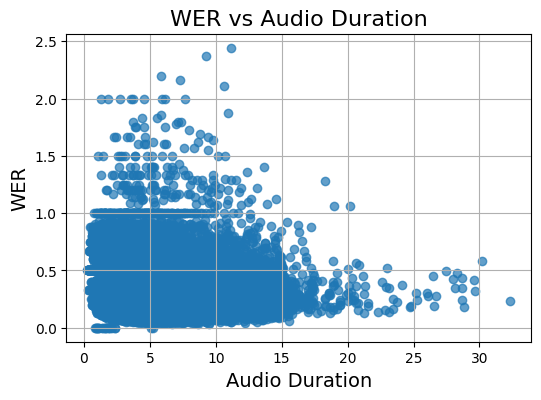

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wav2vec["Duration"], 
    net_aigenerated_data_wav2vec["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

In [16]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Duration'], net_aigenerated_data_wav2vec.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = -0.20088777439536554


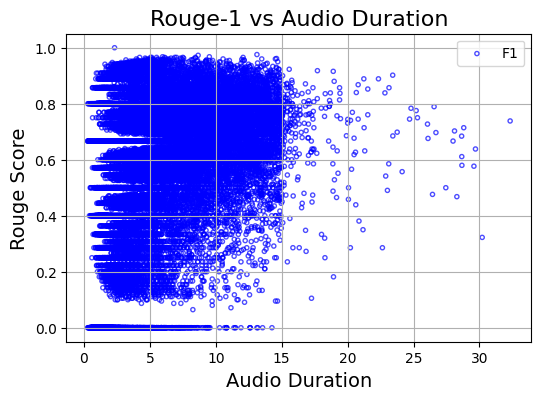

In [8]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wav2vec["Duration"], 
#     net_aigenerated_data_wav2vec["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wav2vec["Duration"], 
#     net_aigenerated_data_wav2vec["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wav2vec["Duration"], 
    net_aigenerated_data_wav2vec["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

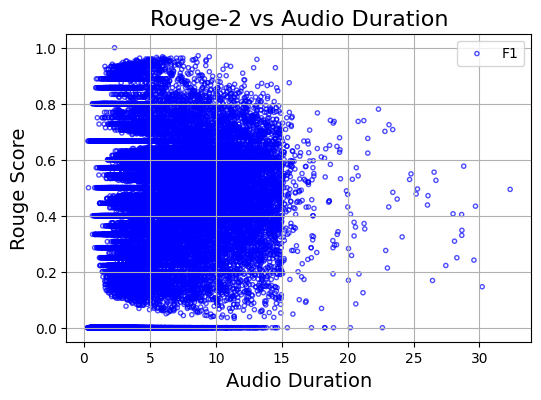

In [11]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wav2vec["Duration"], 
#     net_aigenerated_data_wav2vec["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wav2vec["Duration"], 
#     net_aigenerated_data_wav2vec["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wav2vec["Duration"], 
    net_aigenerated_data_wav2vec["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

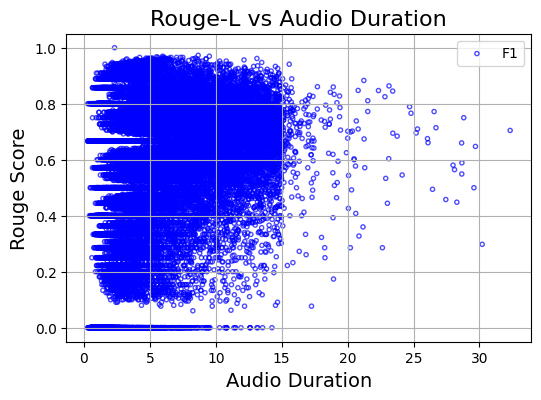

In [14]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wav2vec["Duration"], 
#     net_aigenerated_data_wav2vec["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wav2vec["Duration"], 
#     net_aigenerated_data_wav2vec["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wav2vec["Duration"], 
    net_aigenerated_data_wav2vec["rougel-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Duration'], net_aigenerated_data_wav2vec.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Duration'], net_aigenerated_data_wav2vec.dropna()['rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_wav2vec.dropna()['Duration'], net_aigenerated_data_wav2vec.dropna()['rougel-f1'])
print(f"p-value [stuttering count & rouge-L f1] = {p}")
print(f"rho [stuttering count & rouge-L f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.32688035093028295
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = 0.3461329978593603
p-value [stuttering count & rouge-L f1] = 0.0
rho [stuttering count & rouge-L f1] = 0.2989576297020947


***